In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pyraug
!git clone https://github.com/clementchadebec/pyraug.git
import os
path=os.path.join(os.getcwd(), 'pyraug/examples')
os.chdir(path)

fatal: destination path 'pyraug' already exists and is not an empty directory.


In [3]:
pip install scikit-image

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import torch
from pyraug.trainers.training_config import TrainingConfig
from pyraug.pipelines.training import TrainingPipeline
from pyraug.models.rhvae import RHVAEConfig
from pyraug.models import RHVAE
from pyraug.pipelines.generation import GenerationPipeline
from pyraug.models.nn import BaseEncoder, BaseDecoder
import torch.nn as nn
import random
import numpy as np
from skimage.metrics import structural_similarity as compare_ssim

In [5]:
file_list = os.listdir('/content/drive/MyDrive/MSc data/data-4-genam-202209')
array_list = []
for file_name in file_list:
  file_path = os.path.join('/content/drive/MyDrive/MSc data/data-4-genam-202209', file_name)
  df = pd.read_csv(file_path)
  x_values = df['Points:0'].unique()
  y_values = df['Points:1'].unique()
  z_values = df['Points:2'].unique()
  x_len = len(x_values)
  y_len = len(y_values)
  z_len = len(z_values)
  pivot_df = df.pivot_table(index='Points:2', columns=['Points:1', 'Points:0'], values='phase')
  array_3d = np.array([pivot_df[col].values for col in pivot_df.columns]).reshape(x_len, y_len, z_len)
  array_list.append(array_3d)
real_data_4_amp = np.stack(array_list)

In [6]:
file_list = os.listdir('/content/drive/MyDrive/MSc data/data-8-genam-202209')
array_list = []
for file_name in file_list:
  file_path = os.path.join('/content/drive/MyDrive/MSc data/data-8-genam-202209', file_name)
  df = pd.read_csv(file_path)
  x_values = df['Points:0'].unique()
  y_values = df['Points:1'].unique()
  z_values = df['Points:2'].unique()
  x_len = len(x_values)
  y_len = len(y_values)
  z_len = len(z_values)
  pivot_df = df.pivot_table(index='Points:2', columns=['Points:1', 'Points:0'], values='phase')
  array_3d = np.array([pivot_df[col].values for col in pivot_df.columns]).reshape(x_len, y_len, z_len)
  array_list.append(array_3d)
real_data_8_amp = np.stack(array_list)

In [7]:
file_list = os.listdir('/content/drive/MyDrive/MSc data/data-16-genam-202210')
array_list = []
for file_name in file_list:
  file_path = os.path.join('/content/drive/MyDrive/MSc data/data-16-genam-202210', file_name)
  df = pd.read_csv(file_path)
  x_values = df['Points:0'].unique()
  y_values = df['Points:1'].unique()
  z_values = df['Points:2'].unique()
  x_len = len(x_values)
  y_len = len(y_values)
  z_len = len(z_values)
  pivot_df = df.pivot_table(index='Points:2', columns=['Points:1', 'Points:0'], values='phase')
  array_3d = np.array([pivot_df[col].values for col in pivot_df.columns]).reshape(x_len, y_len, z_len)
  array_list.append(array_3d)
real_data_16_amp = np.stack(array_list)

In [8]:
file_list = os.listdir('/content/drive/MyDrive/MSc data/data-32-genam-202210')
array_list = []
for file_name in file_list:
  file_path = os.path.join('/content/drive/MyDrive/MSc data/data-32-genam-202210', file_name)
  df = pd.read_csv(file_path)
  x_values = df['Points:0'].unique()
  y_values = df['Points:1'].unique()
  z_values = df['Points:2'].unique()
  x_len = len(x_values)
  y_len = len(y_values)
  z_len = len(z_values)
  pivot_df = df.pivot_table(index='Points:2', columns=['Points:1', 'Points:0'], values='phase')
  array_3d = np.array([pivot_df[col].values for col in pivot_df.columns]).reshape(x_len, y_len, z_len)
  array_list.append(array_3d)
real_data_32_amp = np.stack(array_list)

In [9]:
real_data_4_amp = torch.tensor(real_data_4_amp, dtype=torch.float32)
real_data_8_amp = torch.tensor(real_data_8_amp, dtype=torch.float32)
real_data_16_amp = torch.tensor(real_data_16_amp, dtype=torch.float32)
real_data_32_amp = torch.tensor(real_data_32_amp, dtype=torch.float32)

In [10]:
data_min = torch.min(real_data_4_amp)
data_max = torch.max(real_data_4_amp)
real_data_4_amp_normalized = (real_data_4_amp - data_min) / (data_max - data_min)
data_min = torch.min(real_data_8_amp)
data_max = torch.max(real_data_8_amp)
real_data_8_amp_normalized = (real_data_8_amp - data_min) / (data_max - data_min)
data_min = torch.min(real_data_16_amp)
data_max = torch.max(real_data_16_amp)
real_data_16_amp_normalized = (real_data_16_amp - data_min) / (data_max - data_min)
data_min = torch.min(real_data_32_amp)
data_max = torch.max(real_data_32_amp)
real_data_32_amp_normalized = (real_data_32_amp - data_min) / (data_max - data_min)

In [11]:
real_data_4_amp_normalized = real_data_4_amp_normalized.view(1024,100)
real_data_8_amp_normalized = real_data_8_amp_normalized.view(1024,567)
real_data_16_amp_normalized = real_data_16_amp_normalized.view(1024,3468)
real_data_32_amp_normalized = real_data_32_amp_normalized.view(1024,25047)

In [12]:
random_indices = torch.randperm(1024)
real_data_4_amp_normalized = real_data_4_amp_normalized[random_indices]
training_4_amp = real_data_4_amp_normalized[:900, :]
test_4_amp = real_data_4_amp_normalized[900:, :]

In [13]:
random_indices = torch.randperm(1024)
real_data_8_amp_normalized = real_data_8_amp_normalized[random_indices]
training_8_amp = real_data_8_amp_normalized[:900, :]
test_8_amp = real_data_8_amp_normalized[900:, :]

In [14]:
random_indices = torch.randperm(1024)
real_data_16_amp_normalized = real_data_16_amp_normalized[random_indices]
training_16_amp = real_data_16_amp_normalized[:900, :]
test_16_amp = real_data_16_amp_normalized[900:, :]

In [15]:
random_indices = torch.randperm(1024)
real_data_32_amp_normalized = real_data_32_amp_normalized[random_indices]
training_32_amp = real_data_32_amp_normalized[:900, :]
test_32_amp = real_data_32_amp_normalized[900:, :]

In [16]:
def compute_cosine_similarity(array1, array2):
    if array1.shape != array2.shape:
        raise ValueError("different size")
    vector1 = array1.reshape(-1)
    vector2 = array2.reshape(-1)

    dot_product = np.dot(vector1, vector2)

    norm1 = np.linalg.norm(vector1)
    norm2 = np.linalg.norm(vector2)

    cosine_similarity = dot_product / (norm1 * norm2)

    return cosine_similarity

In [17]:
def compute_ssim_3d(array1, array2, win_size=3):
    if array1.shape != array2.shape:
        raise ValueError("different size")

    ssim_values = []

    for i in range(array1.shape[0]):
        slice1 = array1[i, :, :]
        slice2 = array2[i, :, :]
        ssim_score, _ = compare_ssim(slice1, slice2, win_size=3, multichannel=False, full=True)
        ssim_values.append(ssim_score)

    mean_ssim = np.mean(ssim_values)
    return mean_ssim

In [38]:
class Encoder_Conv(BaseEncoder):
    def __init__(self, args):
        BaseEncoder.__init__(self)
        self.latent_dim = args.latent_dim

        self.layers = nn.Sequential(
            nn.Linear(3468, 500),
            nn.ReLU(),
            nn.Linear(500, 200),
            nn.ReLU(),
        )


        self.mu = nn.Linear(200, self.latent_dim)
        self.std = nn.Linear(200, self.latent_dim)

    def forward(self, x):
        out = self.layers(x)
        return self.mu(out), self.std(out)


class Decoder_Conv(BaseDecoder):
    def __init__(self, args):
        BaseDecoder.__init__(self)

        self.latent_dim = args.latent_dim

        self.fc1 = nn.Sequential(
            nn.Linear(self.latent_dim, 200),
            nn.ReLU(),
            nn.Linear(200, 500),
            nn.ReLU(),
            nn.Linear(500, 3468),
            nn.Sigmoid()
        )


    def forward(self, z):
        out = self.fc1(z)
        return out

In [45]:
model_config = RHVAEConfig(
    input_dim=12*17*17, # This is needed since we do not provide any encoder, decoder and metric architecture
    latent_dim=20)

In [46]:
encoder = Encoder_Conv(model_config)
decoder= Decoder_Conv(model_config)

In [47]:
model = RHVAE(
    model_config=model_config,
    encoder=encoder,
    decoder=decoder
)

In [48]:
training_config = TrainingConfig(
    output_dir='my_model_with_custom_archi',
    no_cuda=False,
    learning_rate=1e-3,
    batch_size=50,
    train_early_stopping=100,
    steps_saving=None,
    max_epochs=200)

In [49]:
pipeline = TrainingPipeline(
    data_loader=None,
    data_processor=None,
    model=model,
    optimizer=None,
    training_config=training_config)

In [ ]:
torch.manual_seed(7)
torch.cuda.manual_seed(7)

pipeline(
    train_data=training_16_amp,
    eval_data=training_16_amp,
    log_output_dir='output_logs'
)

Data normalized using individual_min_max_scaling.
INFO:pyraug.data.preprocessors:Data normalized using individual_min_max_scaling.
 -> If this is not the desired behavior pass an instance of DataProcess with 'data_normalization_type' attribute set to desired normalization or None

INFO:pyraug.data.preprocessors: -> If this is not the desired behavior pass an instance of DataProcess with 'data_normalization_type' attribute set to desired normalization or None

Data normalized using individual_min_max_scaling.
INFO:pyraug.data.preprocessors:Data normalized using individual_min_max_scaling.
 -> If this is not the desired behavior pass an instance of DataProcess with 'data_normalization_type' attribute set to desired normalization or None

INFO:pyraug.data.preprocessors: -> If this is not the desired behavior pass an instance of DataProcess with 'data_normalization_type' attribute set to desired normalization or None

Model passed sanity check !

INFO:pyraug.trainers.trainers:Model passed 

In [ ]:
inputs = {"data": training_16_amp}
output= model(inputs)

In [ ]:
mu = output.mu.detach().numpy()

In [29]:
pip install scikit-learn

In [30]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(mu)

In [ ]:
tsne = TSNE(n_components=2)
reduced_data2 = tsne.fit_transform(mu)

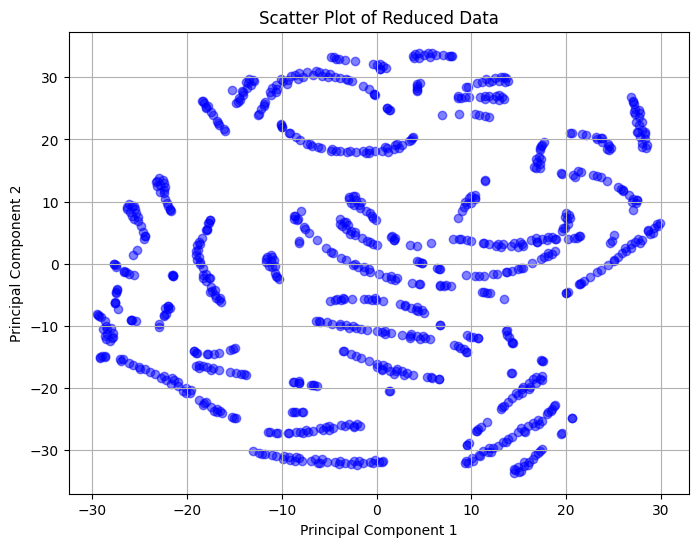

In [ ]:
x = reduced_data2[:, 0]
y = reduced_data2[:, 1]

plt.figure(figsize=(8, 6))
plt.scatter(x, y, c='blue', alpha=0.5)
plt.title('Scatter Plot of Reduced Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()